# Check_spinup global results
- reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS/OUTPUT_CN/SPIN

#### --- CRUNCEP runs  --- :
- `MIMICS_def`, as in GRL 2019 paper, but with additional CN parameters
- `MIMICS_desorb`, increased desorb 5x as in Zhang 2000 paper
- `MIMICS_desorb2` decreased desorb 10x from default, decreased fPHYS 5x from default
            FI: FI_phys = 0.005, 10x lower, FI_chem = 0.10, 2x higher;  
            KO = 9 (from 6) to increase SOMc stocks

#### --- GSWP3 runs  --- : 
- `MIMICS_desorb2_GSWP3` as above, but pointing to  GSPW3
- `MIMICS_mod3_GSWP3`, increase KO = 12, and double MIC turnover to increase SOC stocks and reduce MIC
- `MIMICS_mod3_borealNfix_GSWP3`, increase Nfix in boreal systems **maybe revert?**

#### --- Increased MIMICS leaching & modifiend density dependend parameterizaiton ---
   **Switched to updated CLM5-GSWP3 inputs (created with ctsm_dev110 tag)**
- `MIMICS_mod4_GSWP3`,  leaching as fraction of total DIN pool
- `MIMICS_mod4_dens1.0_GSWP3`, density dependent exponent = 1
- **`MIMICS_mod4_dens1.0_KO6_GSWP3`**, KO = 6, turnover * desorbtion as in `MIMICS_desorb2`
  - Seems like the **best** run & most similar to previously published C-only simulations
  - Trying to improve variation in microbial and soil C:N, however, with subsequent simulations
- `MIMICS_mod4_dens1.0_KO6_micCN_GSWP3`, as above, but includes flexible microbial CN
  - These simulations had funny chages in NPP and TOTC, the later showing > 3 gC/m2/100 years in isotalated grid cells, even after 20k year spinup.
  - Also, MIMCScn has large and increasing CWDc pools in all cases, mainly in boreal forests
  - CASA logic for N limitation (xknlimiting) was still being used for CWD decay into LITs.
  - WRW removed this in the code and repeated MIMCScn simulations to test results.
- `MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3`, as above, but reverting boreal NFix as origionally in CASA

#### --- Finally, the runs we'll use? ---
- **`MIMICS_mod5_GSWP3`**, As above, increasing `FI(struc)` to 0.3 (from 0.1) to increase soil C:N
  - Considering making this flux a function of `fmet` too.  Here's just testing the sensitivity of the model to the change
- `MIMICS_mod5_Conly`, C-only of above
- `CASACNP_mod4_GSWP3`, currently as in `MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3`
- `CASACNP_mod4_Conly`

In [1]:
import xarray as xr
import xesmf as xe  # to regrid observations
import dask.array as da  # need to have dask.array installed, although not directly using it here.
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print(xr.__version__)
%matplotlib inline

0.16.1


#### User defined options

In [2]:
#some logicals to use later on
model = 'mim' 
CN = True
compare = True   #to compare & plot two cases

path = '/project/tss/wwieder/biogeochem_testbed_1.1/'
sim  = 'MIMICS_mod5_GSWP3'  #'CASACNP_mod4_GSWP3' 
sim2 = 'MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3'  #second case to compare  with

if CN == True:
    case  = 'GRID_CN/'+sim+ '/OUTPUT_CN/SPIN2/'
    case2 = 'GRID_CN/'+sim2+'/OUTPUT_CN/SPIN2/'
else:
    case = 'GRID_CN/'+sim+'/OUTPUT_C/SPIN2/'


#### Point to and open datasets

In [3]:
full_pathMIM = path+case+'mimics_pool_flux_*80.nc'  # read in data every 100 years
full_pathCAS = path+case+'casaclm_pool_flux_*80.nc' # casa files for vegetation results
full_pathMIM2 = path+case2+'mimics_pool_flux_*80.nc'  
full_pathCAS2 = path+case2+'casaclm_pool_flux_*80.nc' 

print(full_pathCAS)

if model == 'mim':
    ds   = xr.open_mfdataset(full_pathMIM, decode_times=True, combine='by_coords')
    dsVeg= xr.open_mfdataset(full_pathCAS, decode_times=True, combine='by_coords')
    ds = xr.combine_by_coords([ds, dsVeg], compat='override',data_vars='all',combine_attrs='override')

    if compare == True:
        ds2   = xr.open_mfdataset(full_pathMIM2, decode_times=True, combine='by_coords')
        dsVeg2= xr.open_mfdataset(full_pathCAS2, decode_times=True, combine='by_coords')
        ds2 = xr.combine_by_coords([ds2, dsVeg2], compat='override',data_vars='all',combine_attrs='override')
        
if model == 'cas':
    ds = xr.open_mfdataset(full_pathCAS, decode_times=True, combine='by_coords')
    
print('-- read in dataset -- ')

/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3/OUTPUT_CN/SPIN2/casaclm_pool_flux_*80.nc
-- read in dataset -- 


In [4]:
# sum soil C & N pools
# mask out low productivity cells
minNPP = 10
ds = utils.sum_pools(ds, model)
ds = ds.where(ds['cnpp']>minNPP)
if compare == True:
    ds2 = utils.sum_pools(ds2, model)
    ds2 = ds2.where(ds2['cnpp']>minNPP)

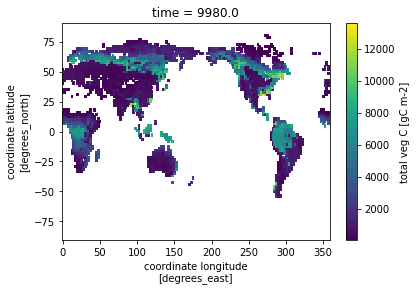

In [5]:
ds.cVEG.isel(time=-1).plot();

## Define function for global sum & spatial plots

In [6]:
area = ds.landarea.isel(time=-1) *1e6
def globalSum (dsIn, var, area=area, time=0, conversion=1e-15, units=None, plot=True, Round=False, sim=sim ):
    "Global weighted sum of fluxes & states"
    temp = dsIn[var] * area 
    temp = temp.sum(dim=('lat','lon')) * conversion
    if plot==True:
        plt.figure(figsize=[25,6]);
        for i in range(len(var)):
            plt.subplot(1, len(var), (1+i))
            plt.ylabel('Global '+var[i]+' (Pg C y^-1)')
            if i == 0:
                plt.title(sim,loc='left', fontsize='xx-large')
            if Round==True:
                plt.plot(temp['time'], temp[var[i]].round(2));
            else:
                plt.plot(temp['time'], temp[var[i]]);
    else:
        for i in range(len(var)):
            print('global '+var[i]+' '+str(np.round(temp[var[i]].isel(time=-1).values,1) )+' Pg C')

In [7]:
# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:  # here to right of plots
        fig.colorbar(im, ax=ax,shrink=0.40, pad=0, fraction = 0.1)

    # allows for different colorbars on each plot
    if cb == 2:  # here below plots
        fig.colorbar(im, ax=ax,shrink=0.9, pad=0, fraction = 1, orientation="horizontal")

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

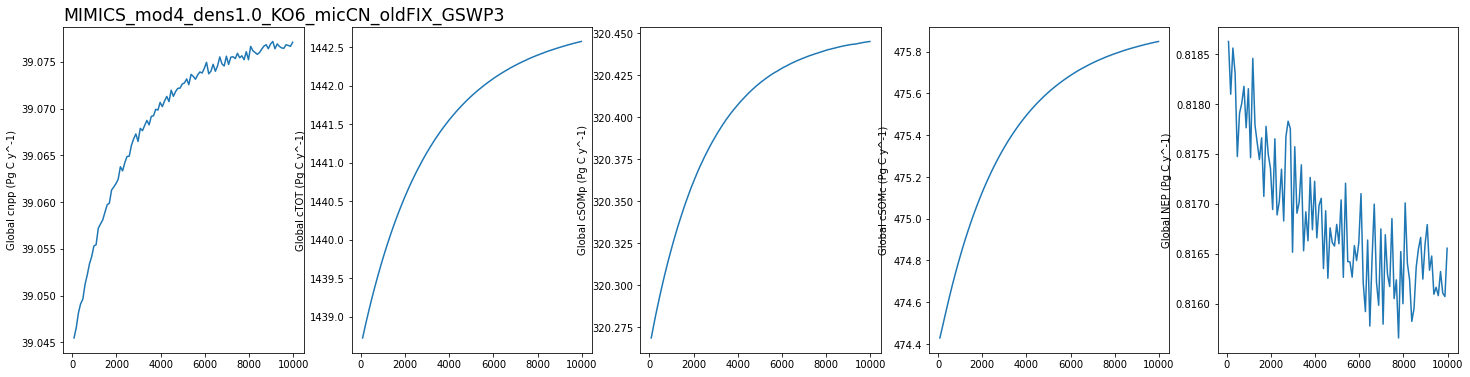

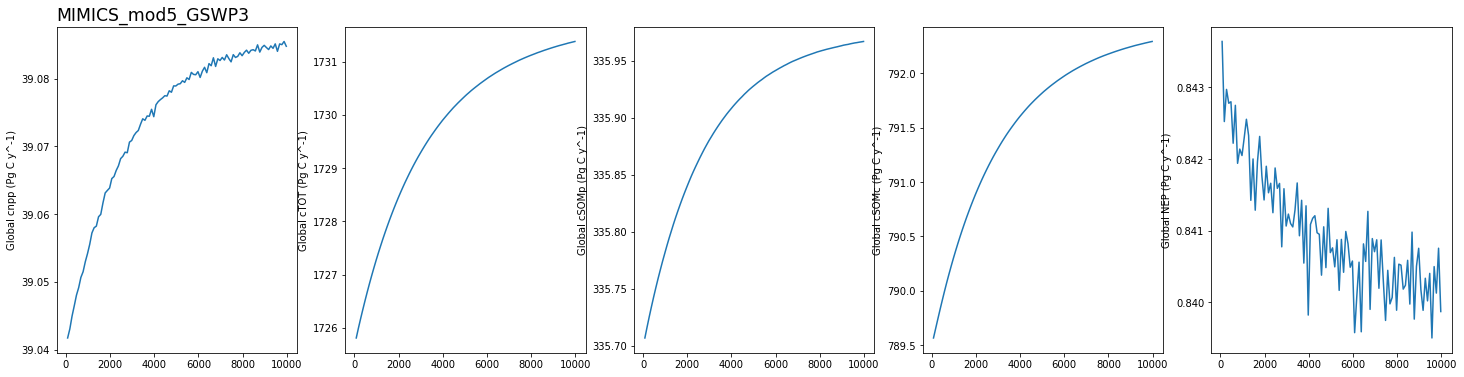

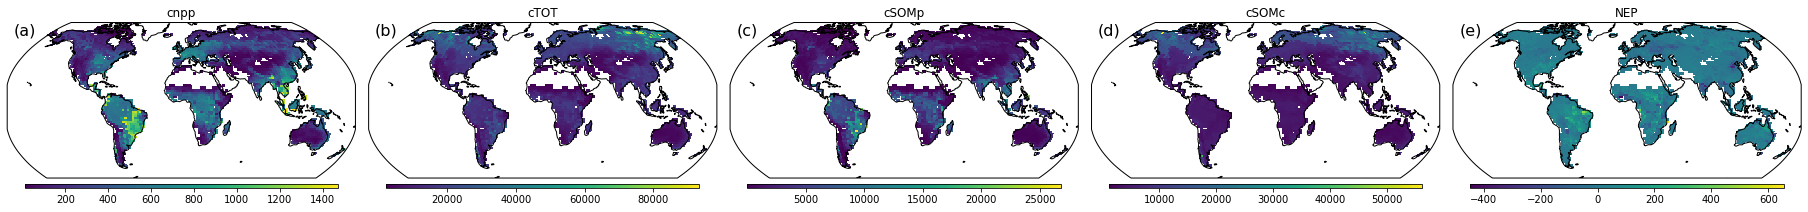

In [8]:
if model == 'mim':
    Cvars =['cnpp','cTOT','cSOMp','cSOMc','NEP']
else:
    Cvars =['cnpp','cTOT','clitcwd']

if compare == True:
    globalSum(ds2,Cvars, plot=True, Round=False, sim=sim2)

globalSum(ds,Cvars, plot=True, Round=False, sim=sim)

# Now call the map_function
fig, axes = plt.subplots(nrows=1, ncols=len(Cvars), figsize=((5*len(Cvars)),6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ds[Cvars[index[0]]].isel(time=-1)
    map_function(da, panel=panel[i], ax=ax, title=Cvars[index[0]], cb=2)

### Look at changes in soil pools in last 100 years

change cECO = 0.0 Pg C / 100.0 years 


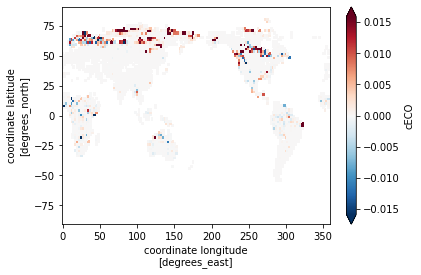

In [9]:
d_ds = (ds.isel(time=-1) - ds.isel(time=-2)) / (ds.time.isel(time=-1) - ds.time.isel(time=-2) )
f_ds = d_ds/ds.isel(time=-1)*100
d_ds['cECO'].plot(robust=True);

#ds['cTOT'].isel(time=-1).plot(robust=True)

temp = d_ds['cECO'] * area 
temp = temp.sum(dim=('lat','lon')) * 1e-15
dtime = (ds.time.isel(time=-1) - ds.time.isel(time=-2))
         
print('change cECO = '+str(np.round(temp.values,3))+' Pg C / '+str(dtime.values)+' years ')

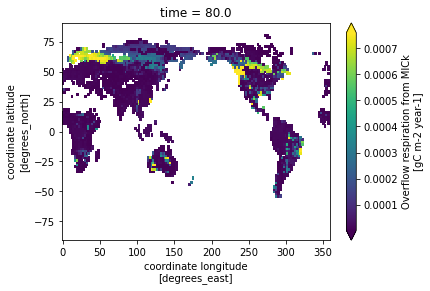

In [10]:
#print(ds)
ds['cOverflow_k'].isel(time=0).plot(robust=True);

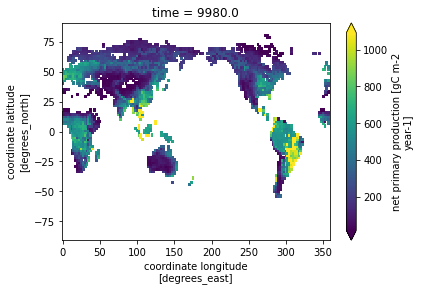

In [11]:
ds['cnpp'].isel(time=-1).plot(robust=True);

------------------
## Quick look at latest state of model

cnTOT
  MIMICS_mod5_GSWP3 mean= 12.8 min= 6.3 max= 21.6
  MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3 mean= 11.1 min= 6.1 max= 17.7
cnMIC
  MIMICS_mod5_GSWP3 mean= 6.9 min= 5.2 max= 9.8
  MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3 mean= 7.1 min= 5.2 max= 10.1
relMIC
  MIMICS_mod5_GSWP3 mean= 0.7 min= 0.1 max= 3.5
  MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3 mean= 0.9 min= 0.1 max= 4.1


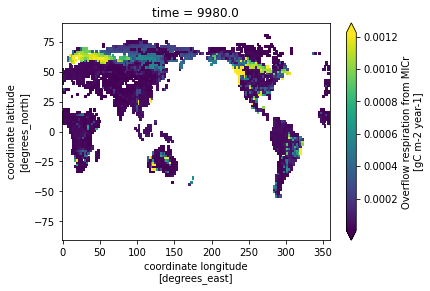

In [12]:
meanVars = ['cnTOT','cnMIC', 'relMIC']
for i in range(len(meanVars)):
    print(meanVars[i]) 
    print('  '+sim+
          ' mean= '+str(np.round(ds[meanVars[i]].mean().values,1))+
          ' min= '+ str(np.round(ds[meanVars[i]].min().values,1))+
          ' max= '+ str(np.round(ds[meanVars[i]].max().values,1)))
    if compare==True:
        print('  '+sim2+
              ' mean= '+str(np.round(ds2[meanVars[i]].mean().values,1))+
              ' min= ' +str(np.round(ds2[meanVars[i]].min().values,1))+
              ' max= ' +str(np.round(ds2[meanVars[i]].max().values,1)))

ds.cOverflow_r.isel(time=-1).plot(robust=True);

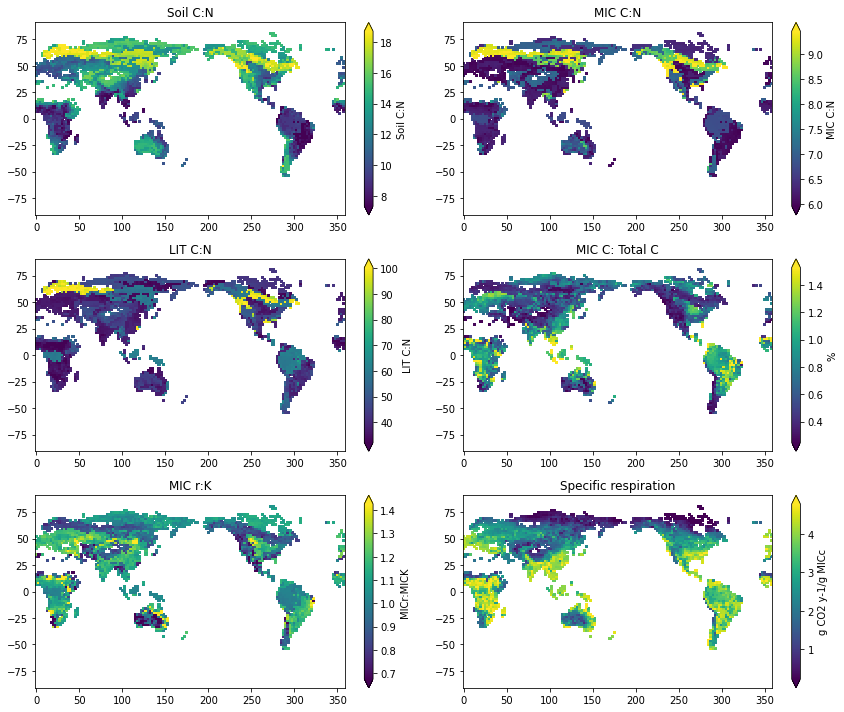

In [13]:
ncols = 2
nrows = 3
#  lists of variables, titles & labels
plotVars = ['cnTOT','cnMIC','cnLIT','relMIC','MICrK','specRESP']
plotTitle = ['Soil C:N','MIC C:N','LIT C:N','MIC C: Total C','MIC r:K','Specific respiration']
plotLable = 'Soil C:N','MIC C:N','LIT C:N','%','MICr:MICK', 'g CO2 y-1/g MICc'

# create the plots
fig = plt.figure(figsize=(12,10))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
for ax in axes:
    ds[plotVars[i]].isel(time=-1).plot(ax=ax, robust=True, cbar_kwargs={'label': plotLable[i]})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[i])
    i = i+1

plt.tight_layout()

# Read observations:
- Microbial C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


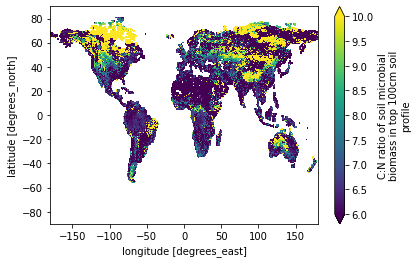

In [14]:
obsIn = "/project/tss/wwieder/soilCN/global_run/"

xuMic = obsIn+'GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264/data/Global_Soil_Microbial_BiomassCN.nc'
dsXu = xr.open_mfdataset(xuMic, decode_times=True,combine='by_coords')
dsXu.CN100cm.plot(vmax=10,vmin=6);

GSDE = obsIn+'GSDE/'
GSDEoc = xr.open_mfdataset(GSDE+'OC5min.nc', decode_times=True,combine='by_coords')
GSDEtn = xr.open_mfdataset(GSDE+'TN5min.nc', decode_times=True,combine='by_coords')
GSDEoc['CN'] = GSDEoc.OC / GSDEtn.TN.where(GSDEtn.TN>0)
GSDEoc['CNmean'] = GSDEoc.CN.where(GSDEoc.depth<=100).mean(dim='depth')
# Mask out crazy results
GSDEoc['CNmean'] = GSDEoc['CNmean'].where(GSDEoc['CNmean']<150)

HWSD = obsIn+'input_data/Soil_obs.nc'
dsOBS = xr.open_mfdataset(HWSD, decode_times=True,combine='by_coords')

NCSCD = obsIn+'input_data/NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsNCSCD = xr.open_mfdataset(NCSCD, decode_times=True,combine='by_coords')

dsHR = xr.open_mfdataset((obsIn+'RH_yr_Hashimoto2015.nc'), decode_times=False,combine='by_coords' )

dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
zon_meanOBS = dsOBS.mean(dim='lon') * 1000 #gC/m2
zon_stdOBS = dsOBS.std(dim='lon') * 1000 #gC/m2

## Regrid observations

In [15]:
dsXu_out = xr.Dataset({'lat': (['lat'], ds.lat),
                     'lon': (['lon'], ds.lon)})
GSDEoc_out = dsXu_out
HWSD_out   = dsXu_out 
NCSCD_out  = dsXu_out

In [16]:
# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.
# Note this is also a pretty quick and dirty job, not sure how coastlines are bing handled?
XuRegridder = xe.Regridder(dsXu, dsXu_out, 'bilinear',periodic=True, reuse_weights=True)
GSDEregridder = xe.Regridder(GSDEoc, GSDEoc_out, 'bilinear',periodic=True, reuse_weights=True)
HWSDregridder = xe.Regridder(dsOBS['HWSD_SOCall'], HWSD_out, 'bilinear',periodic=True, reuse_weights=True)
NCSCDregridder = xe.Regridder(dsNCSCD, NCSCD_out, 'bilinear',periodic=True, reuse_weights=True)
#XuRegridder  # print basic regridder information.

Reuse existing file: bilinear_360x720_96x144_peri.nc
Reuse existing file: bilinear_1680x4320_96x144_peri.nc
Reuse existing file: bilinear_192x288_96x144_peri.nc
Reuse existing file: bilinear_268x1440_96x144_peri.nc


In [17]:
dsXu_out = XuRegridder(dsXu)
GSDEoc_out = GSDEregridder(GSDEoc)
HWSD_out = HWSDregridder(dsOBS['HWSD_SOCall'])
NCSCD_out = NCSCDregridder(dsNCSCD)

dsXu_out = dsXu_out.where(ds.cnpp.isel(time=-1)>minNPP)
GSDEoc_out = GSDEoc_out.where(ds.cnpp.isel(time=-1)>minNPP)
HWSD_out = HWSD_out.where(ds.cnpp.isel(time=-1)>minNPP)
NCSCD_out = NCSCD_out.where(ds.cnpp.isel(time=-1)>minNPP)

using dimensions ('lat', 'lon') from data variable BIOME as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable OC as the horizontal dimensions for this dataset.


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


using dimensions ('lat', 'lon') from data variable NCSCD_SOC as the horizontal dimensions for this dataset.


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [18]:
#dsNCSCD

#### Plot observations and model together

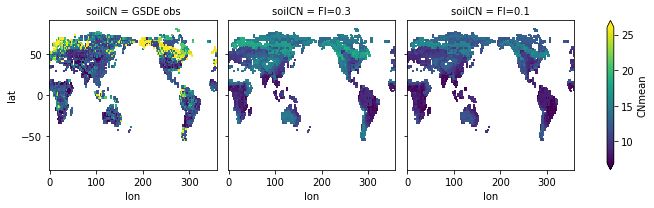

In [19]:
soilCN = xr.concat([GSDEoc_out['CNmean'],ds.cnTOT.isel(time=-1),ds2.cnTOT.isel(time=-1)], 'soilCN')
soilCN['soilCN'] = ['GSDE obs','FI=0.3','FI=0.1']
g_simple = soilCN.plot(x="lon", y="lat", col="soilCN", col_wrap=3,robust=True)

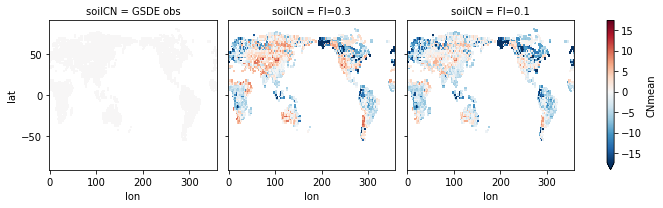

In [20]:
soilCNdiff = soilCN - soilCN.isel(soilCN=0)
g_simple = soilCNdiff.plot(x="lon", y="lat", col="soilCN", col_wrap=3,robust=True)

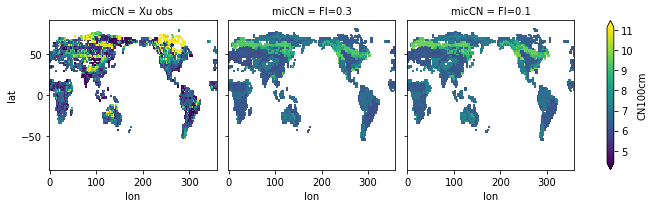

In [21]:
micCN = xr.concat([dsXu_out.CN100cm,ds.cnMIC.isel(time=-1),ds2.cnMIC.isel(time=-1)], 'micCN')
micCN['micCN'] = ['Xu obs','FI=0.3','FI=0.1']
g_simple = micCN.plot(x="lon", y="lat", col="micCN", col_wrap=3,robust=True)

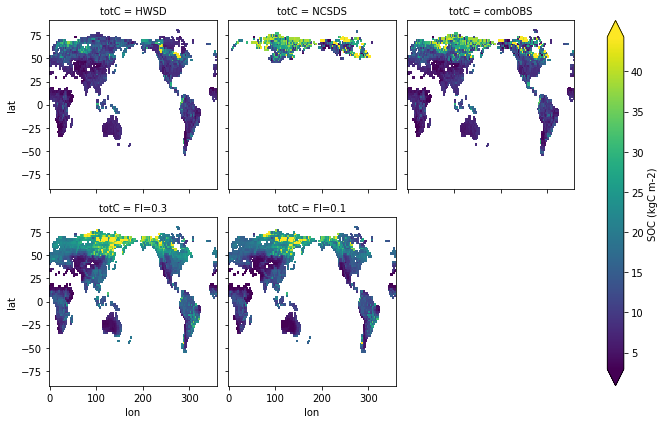

In [22]:
#need bulk density to get GSDE #'s, provided as %C
#GSDEoc_out['OC_1m'] = GSDEoc_out.OC.isel(depth=slice(0,6)).sum(dim='depth')
#GSDEoc_out['OC_1m'] = GSDEoc_out['OC_1m'].where(GSDEoc_out['OC_1m']>0)
NCSCD_out['NCSCD_SOC'] = NCSCD_out.NCSCD_SOC.where(NCSCD_out.lat>25)
#combine datasets, all units gC/m2
combOBS = (HWSD_out)
combOBS = combOBS.where(NCSCD_out['NCSCD_SOC'].isnull(),(0.1*NCSCD_out['NCSCD_SOC'])) 
totC = xr.concat([(HWSD_out),(0.1*NCSCD_out.NCSCD_SOC),combOBS,
                  (1e-3*ds.cTOT.isel(time=-1)),(1e-3*ds2.cTOT.isel(time=-1))], 'totC')
totC['totC'] = ['HWSD','NCSDS','combOBS','FI=0.3','FI=0.1']
g_simple = totC.plot(x="lon", y="lat", col="totC", col_wrap=3,robust=True,cbar_kwargs={'label': 'SOC (kgC m-2)'})#, norm=colors.LogNorm(vmax=1e5, vmin=1e4))


### unweighted zonal means

In [23]:
zon_meanCNmim = ds.mean(dim='lon') 
if compare == True:
    zon_meanCNmim2 = ds2.mean(dim='lon') 

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


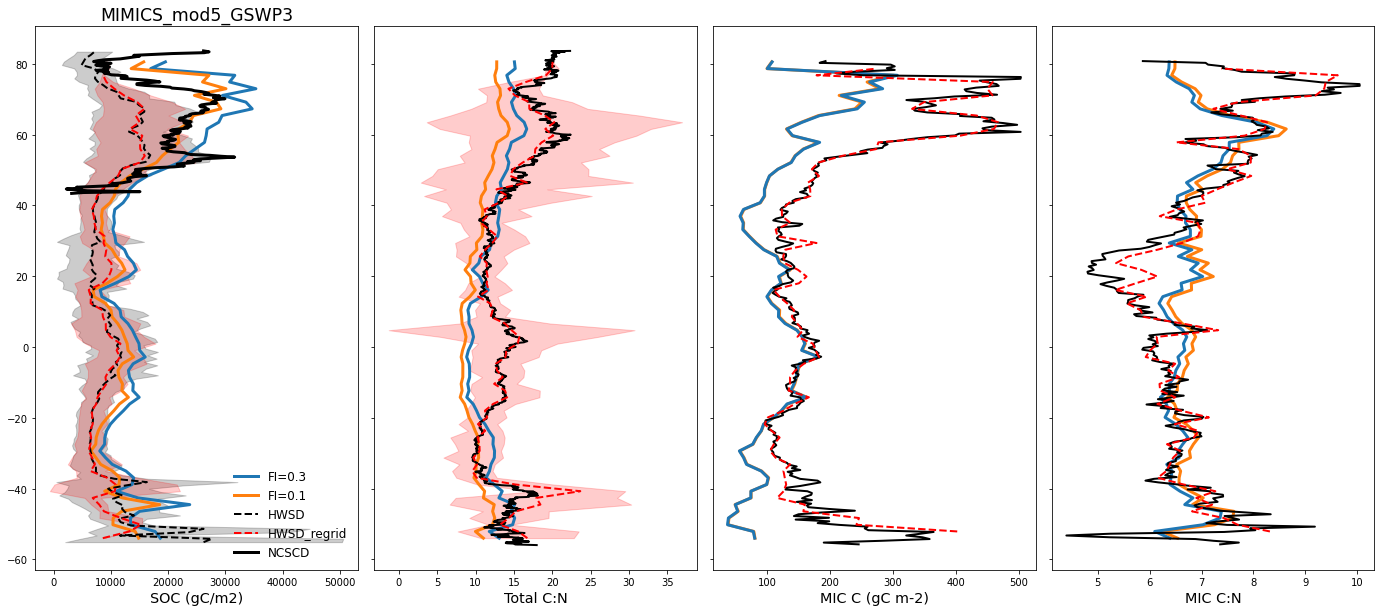

In [24]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, sharey=True, figsize=[24,10])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)
color = ['tab:blue','tab:orange'] # for MIM, CAS
linestyle= ['-', '--']            # for CN,  Conly

v = ['cTOT','cnTOT','cMICtot', 'cnMIC'] #'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'

# SOC
labels = [sim,'HWSD','NCSCD']
ax1.plot(zon_meanCNmim.get('cTOT').isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
if compare == True:
    ax1.plot(zon_meanCNmim2.get(v[0]).isel(time=-1), zon_meanCNmim2.lat,lw=3,color=color[1],linestyle=linestyle[0])
    ax2.plot(zon_meanCNmim2.get(v[1]).isel(time=-1), zon_meanCNmim2.lat,lw=3,color=color[1],linestyle=linestyle[0])
    ax3.plot(zon_meanCNmim2.get(v[2]).isel(time=-1), zon_meanCNmim2.lat,lw=3,color=color[1],linestyle=linestyle[0])
    ax4.plot(zon_meanCNmim2.get(v[3]).isel(time=-1), zon_meanCNmim2.lat,lw=3,color=color[1],linestyle=linestyle[0])
    labels = ['FI=0.3','FI=0.1','HWSD','HWSD_regrid','NCSCD']

ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')#already converted avbove
ax1.fill_betweenx(zon_meanOBS.lat,
                  zon_meanOBS.get('HWSD_SOCall') + zon_stdOBS.get('HWSD_SOCall'), 
                  zon_meanOBS.get('HWSD_SOCall') - zon_stdOBS.get('HWSD_SOCall'),
                  alpha=0.2, color='k')
ax1.plot(HWSD_out.mean(dim='lon')* 1e3 , HWSD_out.lat,lw=2, color='red',linestyle='--') #convert kgC to gC/m2
ax1.fill_betweenx(HWSD_out.lat,
                  HWSD_out.mean(dim='lon')* 1e3 + HWSD_out.std(dim='lon')* 1e3, 
                  HWSD_out.mean(dim='lon')* 1e3 - HWSD_out.std(dim='lon')* 1e3,
                  alpha=0.2, color='red')

ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax1.set_xlabel('SOC (gC/m2)', fontsize='x-large')
ax1.legend(labels=labels, frameon = False, fontsize='large')
ax1.set_title(sim, fontsize='xx-large')

# Soil C:N
ax2.plot(zon_meanCNmim.get(v[1]).isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax2.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
ax2.plot(GSDEoc_out['CNmean'].mean(dim='lon'), GSDEoc_out.lat,lw=2, color='red',linestyle='--')
ax2.fill_betweenx(GSDEoc_out.lat,
                  GSDEoc_out['CNmean'].mean(dim='lon') + GSDEoc_out['CNmean'].std(dim='lon'), 
                  GSDEoc_out['CNmean'].mean(dim='lon') - GSDEoc_out['CNmean'].std(dim='lon'),
                  alpha=0.2, color='red')

ax2.set_xlabel('Total C:N', fontsize='x-large');
labels = ['MIMICScn','Shangguan et al. 2014', 'GSDE regrid']
#ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# MIC tot
ax3.plot(zon_meanCNmim.get(v[2]).isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax3.plot(dsXu_out.SMC100cm.mean(dim='lon'), dsXu_out.lat,lw=2, color='red',linestyle='--')
ax3.set_xlabel('MIC C ('+ds.get(v[2]).attrs['units']+')', fontsize='x-large');
labels = ['MIMICS-CN','Xu et al. 2013','Xu regrid']
#ax2.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# MICcn
ax4.plot(zon_meanCNmim.get(v[3]).isel(time=-1), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax4.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax4.plot(dsXu_out.CN100cm.mean(dim='lon'), dsXu_out.lat,lw=2, color='red',linestyle='--')
ax4.set_xlabel('MIC C:N', fontsize='x-large');
#labels = ['MIMICS-CN','Xu et al. 2013','Xu regrid']

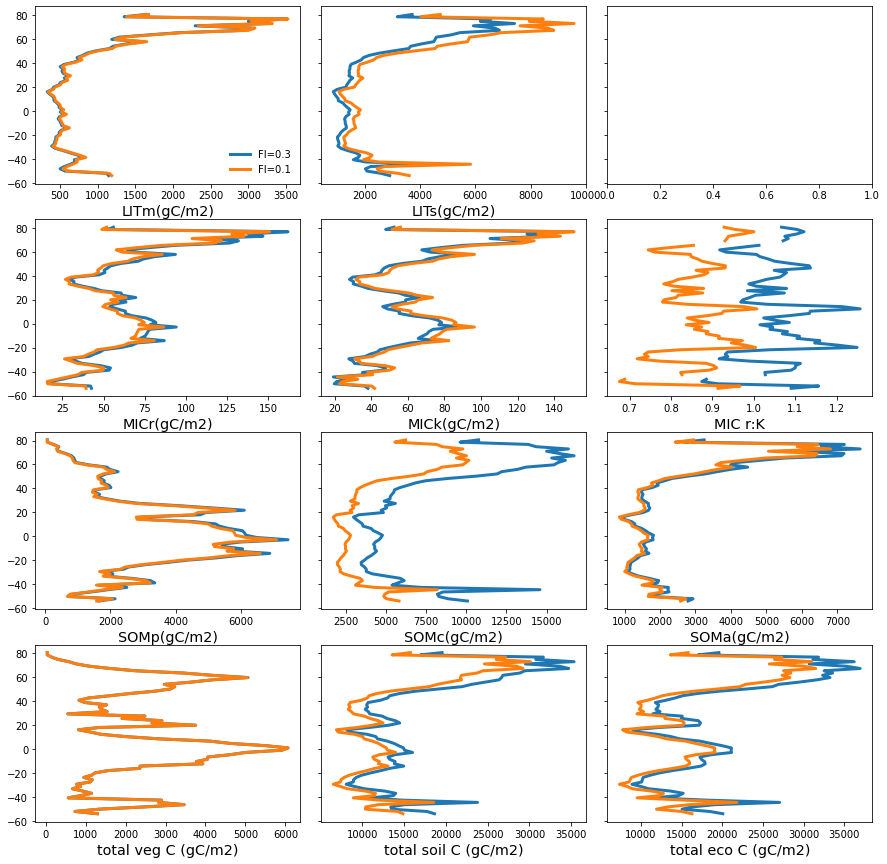

In [25]:
fig, ax = plt.subplots(4, 3, sharey=True, figsize=[15,15])
fig.subplots_adjust(hspace=0.2, wspace=0.08)

ax[0,0].plot(zon_meanCNmim.get('cLITm').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[0,0].set_xlabel('LITm(gC/m2)', fontsize='x-large');

ax[0,1].plot(zon_meanCNmim.get('cLITs').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[0,1].set_xlabel('LITs(gC/m2)', fontsize='x-large');

ax[1,0].plot(zon_meanCNmim.get('cMICr').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[1,0].set_xlabel('MICr(gC/m2)', fontsize='x-large');

ax[1,1].plot(zon_meanCNmim.get('cMICk').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[1,1].set_xlabel('MICk(gC/m2)', fontsize='x-large');

ax[1,2].plot(zon_meanCNmim.get('MICrK').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[1,2].set_xlabel('MIC r:K', fontsize='x-large');

ax[2,0].plot(zon_meanCNmim.get('cSOMp').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[2,0].set_xlabel('SOMp(gC/m2)', fontsize='x-large');

ax[2,1].plot(zon_meanCNmim.get('cSOMc').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[2,1].set_xlabel('SOMc(gC/m2)', fontsize='x-large');

ax[2,2].plot(zon_meanCNmim.get('cSOMa').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[2,2].set_xlabel('SOMa(gC/m2)', fontsize='x-large');

ax[3,0].plot(zon_meanCNmim.get('cVEG').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[3,0].set_xlabel('total veg C (gC/m2)', fontsize='x-large');

ax[3,1].plot(zon_meanCNmim.get('cTOT').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[3,1].set_xlabel('total soil C (gC/m2)', fontsize='x-large');

ax[3,2].plot(zon_meanCNmim.get('cECO').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax[3,2].set_xlabel('total eco C (gC/m2)', fontsize='x-large');

if compare==True:
    ax[0,0].plot(zon_meanCNmim2.get('cLITm').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[0,1].plot(zon_meanCNmim2.get('cLITs').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[1,0].plot(zon_meanCNmim2.get('cMICr').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[1,1].plot(zon_meanCNmim2.get('cMICk').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[1,2].plot(zon_meanCNmim2.get('MICrK').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[2,0].plot(zon_meanCNmim2.get('cSOMp').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[2,1].plot(zon_meanCNmim2.get('cSOMc').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[2,2].plot(zon_meanCNmim2.get('cSOMa').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[3,0].plot(zon_meanCNmim2.get('cVEG').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[3,1].plot(zon_meanCNmim2.get('cTOT').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    ax[3,2].plot(zon_meanCNmim2.get('cECO').isel(time=-1), zon_meanCNmim2.lat, lw=3)
    labels=('FI=0.3','FI=0.1')
    ax[0,0].legend(labels=labels, frameon = False, fontsize='medium',loc=4)


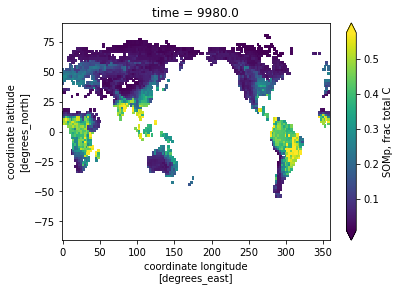

In [26]:
v = ['cSOMp', 'cTOT']
(ds[v[0]] / ds[v[1]]).isel(time=-1).plot(robust=True,cbar_kwargs={'label':'SOMp, frac total C'});
#ds['cTOT'].isel(time=-1).plot(robust=True)

### Correlation between soil stoichoimetry and microbial compostion or microbial C:N
_sensu_ Fierer et al 2009 (Ecology Letters) likely need newer refs.

In [27]:
################### Function to truncate color map ###################
def truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100):
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    arr = np.linspace(0, 50, 100).reshape((10, 10))
    return new_cmap

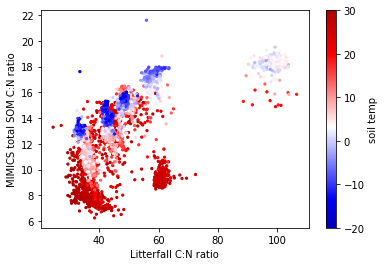

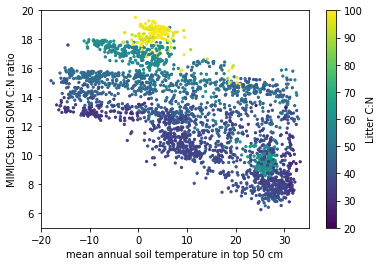

In [28]:
ds_1 = ds.isel(time=-1)
ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

color_by = ds_1.tsoilC
label = 'soil temp'  # Need to rename if 'color_by' is changed

fig, ax = plt.subplots()
s = ax.scatter(ds_1['cnLIT'], ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = -20,            # Min value
               vmax = 30)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds['cnLIT'].attrs['long_name'])
plt.ylabel(ds['cnTOT'].attrs['long_name'])
#ax.set_xlim(20, 110)
plt.show();

color_by = ds_1['cnLIT'] 
label = 'Litter C:N'     
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), constrained_layout=True)
fig, ax = plt.subplots()
s = ax.scatter(ds_1.tsoilC, ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               #cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = 20,            # Min value
               vmax = 100)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds['tsoilC'].attrs['long_name'])
plt.ylabel(ds['cnTOT'].attrs['long_name'])
ax.set_xlim(-20, 35)
ax.set_ylim(5, 20)
plt.show();


**Figure X** Litter quality and temperature interact to control soil C:N. 

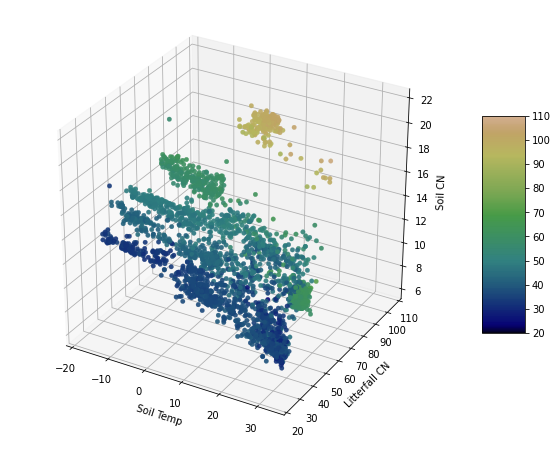

In [29]:
# try above in 3d space
from mpl_toolkits.mplot3d import Axes3D

y = ds_1['cnLIT'].values.ravel()
x = ds_1['tsoilC'].values.ravel()
z = ds_1['cnTOT'].values.ravel()
fig = plt.figure(figsize=[10,8])
ax = fig.gca(projection='3d')

surf = ax.scatter(x, y, z, linewidth=0.3, antialiased=True, 
                  c = y, marker='o', alpha=0.9,
                  cmap = truncate_colormap(cmapIn='gist_earth', minval=.0, maxval=.85),
                  vmin = 20, vmax = 110)          

ax.set_ylim(20, 110)
#ax.set_zlim(8, 15)
ax.set_ylabel('Litterfall CN')
ax.set_xlabel('Soil Temp')
ax.set_zlabel('Soil CN');
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.set_label('Litterfall CN')
plt.show()

---------------------
# Look at MIMCS_Conly w/ GSWP3 & CRU + CASAcn
- `MIMICS_mod4_GSWP3`,  leaching as fraction of total DIN pool
- `MIMICS_mod4_dens1.0_GSWP3`, density dependent exponent = 1
- `MIMICS_mod4_dens1.0_KO6_GSWP3`, KO = 6, turnover * desorbtion as in `MIMICS_desorb2`
- `MIMICS_mod4_dens1.0_KO6_Conly`, C-only of above
- `CASACNP_mod4_GSWP3`
- `CASACNP_mod4_Conly`

In [30]:
cruConlyIN = '/project/tss/wwieder/CASACLM/GRID/OUTPUT_GRID_CRU_NCEP/MIMICS_SPIN_b/'
CcasCRU = cruConlyIN+'casaclm_pool_flux_9000_9980.nc'
CmimCRU = cruConlyIN+'mimics_pool_flux_9000_9980.nc'
print('CmimCRU = ' +CmimCRU)

simMIMc = 'MIMICS_mod5_Conly'
caseMIMc = 'GRID_CN/'+simMIMc+'/OUTPUT_C/SPIN/'
Ccas = path+caseMIMc+'casaclm_pool_flux_*80.nc' 
Cmim = path+caseMIMc+'mimics_pool_flux_*80.nc' 
print('Cmim = '+Cmim)

simCASc  = 'CASACNP_mod4_Conly' 
caseCASc = 'GRID_CN/'+simCASc+'/OUTPUT_C/SPIN2/'
full_pathCASc = path+caseCASc+'casaclm_pool_flux_*80.nc' # casa files for vegetation results
print('Ccas = '+full_pathCASc)

simCAScn  = 'CASACNP_mod4_GSWP3' 
caseCAScn = 'GRID_CN/'+simCAScn+'/OUTPUT_CN/SPIN2/'
full_pathCAScn = path+caseCAScn+'casaclm_pool_flux_*80.nc' # casa files for vegetation results
print('CNcas = '+full_pathCAScn)

CmimCRU = /project/tss/wwieder/CASACLM/GRID/OUTPUT_GRID_CRU_NCEP/MIMICS_SPIN_b/mimics_pool_flux_9000_9980.nc
Cmim = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_Conly/OUTPUT_C/SPIN/mimics_pool_flux_*80.nc
Ccas = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/CASACNP_mod4_Conly/OUTPUT_C/SPIN2/casaclm_pool_flux_*80.nc
CNcas = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/CASACNP_mod4_GSWP3/OUTPUT_CN/SPIN2/casaclm_pool_flux_*80.nc


### Open each dataset

In [31]:
# MIMICS, C-only, CRU-NCEP
dsCmimCRU   = xr.open_mfdataset(CmimCRU, decode_times=True,combine='by_coords') 
dsCvegCRU   = xr.open_mfdataset(CcasCRU, decode_times=True,combine='by_coords')
dsCmimCRU['cnpp'] = dsCvegCRU['cnpp'] # copy plant productivity to mimics files
dsCmimCRU['cgpp'] = dsCvegCRU['cgpp']

# MIMICS, C-only, GSWP3
dsCveg   = xr.open_mfdataset(Ccas,  decode_times=True, combine='by_coords') 
dsCmim   = xr.open_mfdataset(Cmim,  decode_times=True, combine='by_coords') 
dsCmim['cnpp'] = dsCveg['cnpp'] # copy plant productivity to mimics files
dsCmim['cgpp'] = dsCveg['cgpp']

# CASA C-only & CN, GSPW3
dsCcas    = xr.open_mfdataset(full_pathCASc,  decode_times=True, combine='by_coords')
dsCNcas   = xr.open_mfdataset(full_pathCAScn, decode_times=True, combine='by_coords')
print (' -- data read in -- ')

 -- data read in -- 


#### Sum pools & print mean

In [32]:
print(minNPP)
dsCmimCRU = dsCmimCRU.where(dsCmimCRU.cnpp>minNPP)
dsCmim = dsCmim.where(dsCmim.cnpp>minNPP)
dsCcas = dsCcas.where(dsCcas.cnpp>minNPP)
dsCNcas = dsCNcas.where(dsCNcas.cnpp>minNPP)

dsCmimCRU = utils.sum_pools(dsCmimCRU, mod='mim', CN='False')
dsCmim  = utils.sum_pools(dsCmim, mod='mim', CN='False')
dsCcas  = utils.sum_pools(dsCcas,  mod='cas', CN='False')
dsCNcas = utils.sum_pools(dsCNcas, mod='cas', CN='True' )

10


KeyError: 'cleaf'

In [ ]:
Cvars =['cgpp','cnpp','cTOT']
# MIMICS_Conly results, GSWP3
print('')
print('MIMICS_C only GSWP3')
globalSum(dsCmim,Cvars, plot=False)

# MIMICS_CN results
print('')
print(sim+' CN results')
globalSum(ds,Cvars, plot=False)

# CASA_C results
print('')
print('CASA-C, GSWP3 results')
globalSum(dsCcas,Cvars, plot=False)

# CASA_CN results
print('')
print('CASA-CN, GSWP3 results')
globalSum(dsCNcas,Cvars, plot=False)

# MIMICS_C, CRUNCEP
print('')
print('MIMICS_C only CRUNCEP')
globalSum(dsCmimCRU,Cvars, plot=False)

In [ ]:
dsCmim.isel(time=-1).cSOMc.plot(robust=True);

In [ ]:
# Call the map_function
sims = ['MIMICS_Conly ',('MIMICS_CN '),('CASA_CN '), ('CASA_Conly ')]
Cvars =['cgpp','cnpp','cTOT']
vmax = [3000  ,1200  ,5e4]  #max values for each variable

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    i = index[0]
    j = index[1]
    k = k+1
    if j == 0: da = dsCmim[Cvars[i]].isel(time=-1)
    if j == 1: da = ds[Cvars[i]].isel(time=-1)
    if j == 2: da = dsCNcas[Cvars[i]].isel(time=-1)
    if j == 3: da = dsCcas[Cvars[i]].isel(time=-1)

    if j < 3: map_function(da, panel=panel[k], ax=ax, vmax=vmax[i], vmin=0, cb=0, title=sims[j]+Cvars[i])
    else: map_function(da, panel=panel[k], ax=ax, vmax=vmax[i], vmin=0, cb=1, title=sims[j]+Cvars[i])

## Difference in NPP (CN-C)
- most notably in boreal forests.
- somewhat int tropcs

### Call the map_function for: 
- MIMICScn - MIMICS_Conly
- CASAcn - CASA_Conly
- MIMICS_cn - CASA_cn

In [ ]:
inVars  = ['cnpp','cTOT','cSOMp', 'cSOMc']
newVars = ['d_cnpp','d_cTOT','d_cSOMp', 'd_cSOMc']
ds2 = ds.copy(deep=True)
for i in range(len(inVars)):
    # MIMICS-C GSWP3 - MIMICS-C CRUNCEP
    dsCmim[newVars[i]] = (dsCmim[inVars[i]].isel(time=-1) - dsCmimCRU[inVars[i]].isel(time=-1))
    dsCmim[newVars[i]].attrs['long_name'] = 'MIMICS C GSWP3 '+inVars[i]+' difference from CRUNCEP'

    # MIMICS-CN -  MIMICS-Conly GSWP3
    ds[newVars[i]] = (ds[inVars[i]].isel(time=-1) - dsCmim[inVars[i]].isel(time=-1))
    ds[newVars[i]].attrs['long_name'] = 'MIMICScn - MIMICS Conly'

    if (i<2):
        # CASA-CN - CASA-Conly GSWP3
        dsCNcas[newVars[i]] = (dsCNcas[inVars[i]].isel(time=-1) - dsCcas[inVars[i]].isel(time=-1))
        dsCNcas[newVars[i]].attrs['long_name'] = 'CASAcn - CASA Conly'
        
        # MIMICS-CN - CASA-CN GSWP3
        ds2[newVars[i]] = (ds2[inVars[i]].isel(time=-1) - dsCNcas[inVars[i]].isel(time=-1))
        ds2[newVars[i]].attrs['long_name'] = 'MMIMICScn - CASAcn'
        

In [ ]:
Cvars = ['d_cnpp','d_cTOT']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    #print(index)
    i = index[0]
    j = index[1]
    k = k+1
    cb=0
    #if i == 0 : da = dsCmim[Cvars[j]]
    if j == 0 : da = ds[Cvars[i]]
    if j == 1 : da = dsCNcas[Cvars[i]]
    if j == 2 : 
        da = ds2[Cvars[i]]
        cb=1 #turn on CB for right most colum
        
    if i==0:
        #map_function(da, panel=panel[k], ax=ax, title=da.attrs['long_name'], cb=1,cmap='BrBG', vmax=75, vmin=-75) # for % change
        map_function(da, panel=panel[k], ax=ax, title=None, cb=cb,cmap='BrBG', vmax=300, vmin=-300) # for absolute change
    else:
        map_function(da, panel=panel[k], ax=ax, title=None, cb=cb,cmap='BrBG', vmax=2e4, vmin=-2e4)
    

**Fig X** Differences in NPP and total soil C (top and bottom rows, respectively). MIMICScn shows greater N limitatation, shown by lower NPP (a) and lower soil C pools (d), relative to its C-only version. CASAcn shows similar spatial patterns, with lower NPP and soil C stocks than the C-only version of CASA (b,e).  MIMICScn also shows greater N limitation at high latidues than CASAcn (c), but larger global soil C stocks (f).

## Look at zonal mean plots for lat. bands

In [ ]:
var  =  ['cnpp', 'cgpp','cTOT']
varLong  =  ['npp', 'gpp','total soil C']

# weight values by grid cell
ann_fluxCNmim = ds * ds.landarea *1e6
ann_fluxCNcas = dsCNcas * dsCNcas.landarea *1e6
ann_fluxCcas  = dsCcas * dsCcas.landarea *1e6
ann_fluxCmim  = dsCmim * dsCmim.landarea *1e6
ann_fluxCmimCRU = dsCmimCRU * dsCmimCRU.landarea *1e6
for i in range(len(var)):
    ann_fluxCNmim.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCNcas.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCcas.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCmim.get(var[i]).attrs['units'] = 'gC y-1'    
    ann_fluxCmimCRU.get(var[i]).attrs['units'] = 'gC y-1'

In [ ]:
zon_sumCNmim = ann_fluxCNmim.sum(dim='lon') *1e-15
zon_sumCNcas = ann_fluxCNcas.sum(dim='lon') *1e-15
zon_sumCcas = ann_fluxCcas.sum(dim='lon') *1e-15
zon_sumCmim = ann_fluxCmim.sum(dim='lon') *1e-15
zon_sumCmimCRU = ann_fluxCmimCRU.sum(dim='lon') *1e-15
# unweighted zonal means
minGPP = 10
zon_meanCNmim = ds.where(ds.cgpp>minGPP).mean(dim='lon') 
zon_meanCNcas = dsCNcas.where(ds.cgpp>minGPP).mean(dim='lon') 
zon_meanCcas = dsCcas.where(ds.cgpp>minGPP).mean(dim='lon') 
zon_meanCmim = dsCmim.where(ds.cgpp>minGPP).mean(dim='lon') 
zon_meanCmimCRU = dsCmimCRU.where(dsCmimCRU.cgpp>minGPP).mean(dim='lon') 

# Read observations:
- Microbial C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)
color = ['tab:blue','tab:orange'] # for MIM, CAS
linestyle= ['-', '--']            # for CN,  Conly

# NPP
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C']
ax1.plot(zon_meanCNmim.get('cnpp').isel(time=-1), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax1.plot(zon_meanCmim.get('cnpp').isel(time=-1),  zon_meanCmim.lat,  lw=3,color=color[0],linestyle=linestyle[1])
ax1.plot(zon_meanCNcas.get('cnpp').isel(time=-1), zon_meanCNcas.lat, lw=2,color=color[1],linestyle=linestyle[0])
ax1.plot(zon_meanCcas.get('cnpp').isel(time=-1), zon_meanCcas.lat, lw=2,color=color[1],linestyle=linestyle[1])
ax1.set_xlabel('Plant productivity (gC/m2/y)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.set_ylim(-50, 85)
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=1)

# SOC
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C','HWSD','NCSCD']
ax2.plot(zon_meanCNmim.get('cTOT').isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax2.plot(zon_meanCmim.get('cTOT').isel(time=-1),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
ax2.plot(zon_meanCNcas.get('cTOT').isel(time=-1), zon_meanCNcas.lat,lw=2,color=color[1],linestyle=linestyle[0])
ax2.plot(zon_meanCcas.get('cTOT').isel(time=-1), zon_meanCcas.lat,  lw=2,color=color[1],linestyle=linestyle[1])
ax2.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax2.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax2.set_xlabel('Soil C stock (gC/m2)', fontsize='x-large')
ax2.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# Soil C:N
v3 ='cnTOT' #'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax3.plot(zon_meanCNmim.get(v3).isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(zon_meanCNcas.get(v3).isel(time=-1), zon_meanCmim.lat,lw=3,color=color[1],linestyle=linestyle[0])
ax3.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
ax3.set_xlabel('Total SOM C:N', fontsize='x-large');
labels = ['MIMICScn','MIMICS Conly','Shangguan et al. 2014']
ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

'''
ax3.plot(zon_meanCNmim.get('cSOMp').isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(zon_meanCmim.get('cSOMp').isel(time=-1),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
ax3.set_xlabel('SOMp(gC/m2)', fontsize='x-large');

ax4.plot(zon_meanCNmim.get('cSOMc').isel(time=-1), zon_sumCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax4.plot(zon_meanCmim.get('cSOMc').isel(time=-1),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
#ax4.plot(zon_sumCNcas.get('csoilslow').isel(time=-1), zon_meanCNcas.lat, lw=3)
ax4.set_xlabel('SOMc(gC/m2)', fontsize='x-large');
'''

v4 = 'cMICtot' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax4.plot(zon_meanCNmim.get(v4).isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax4.plot(zon_meanCmim.get(v4).isel(time=-1), zon_meanCmim.lat,lw=3,color=color[0],linestyle=linestyle[1])
ax4.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax4.set_xlabel(ds.get(v4).attrs['long_name']+' ('+ds.get(v4).attrs['units']+')', fontsize='x-large');
labels = ['MIMICS-CN','MIMICS-C','Xu et al. 2013']
ax4.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

v5 = 'cnMIC' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax5.plot(zon_meanCNmim.get(v5).isel(time=-1), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
#ax5.plot(zon_meanCNcas.get(v5).isel(time=-1), zon_meanCmim.lat,  lw=3,color=color[1],linestyle=linestyle[0])
ax5.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax5.set_xlabel(ds.get(v5).attrs['long_name'], fontsize='x-large')
#               +' ('+ds.get(v5).attrs['units']+')', fontsize='x-large');


In [ ]:
ax3.plot(zon_meanCNmim.get('cSOMp').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax3.plot(zon_meanCmim.get('cSOMp').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax3.plot(zon_meanCmimCRU.get('cSOMp').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
ax3.set_xlabel('SOMp(gC/m2)', fontsize='x-large');

ax4.plot(zon_meanCNmim.get('cSOMc').isel(time=-1), zon_sumCNmim.lat, lw=3)
ax4.plot(zon_meanCmim.get('cSOMc').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax4.plot(zon_meanCmimCRU.get('cSOMc').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
#ax4.plot(zon_sumCNcas.get('csoilslow').isel(time=-1), zon_meanCNcas.lat, lw=3
ax4.set_xlabel('SOMc(gC/m2)', fontsize='x-large');

ax5.plot(zon_meanCNmim.get('cSOMa').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax5.plot(zon_meanCmim.get('cSOMa').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax5.plot(zon_meanCmimCRU.get('cSOMa').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
#ax5.plot(zon_sumCNcas.get('csoilmic').isel(time=-1), zon_meanCNcas.lat, lw=3
ax5.set_xlabel('SOMa(gC/m2)', fontsize='x-large');

#### NPP
- N limitation reduces NPP in all  models, expecially MIMICS
- CRUNCEP has higher mid & high latitude NPP than GSWP3 forcing

### Total SOM
- lower with CN models, especially in  boreal forest & arctic,  where NPP is lower
- most of MIMICS decreases are in SOMc

### SOM pools
- large drop in SOMc with MIMICScn
- also increases in microbial biomass (fraction of total SOM)
- modify microbial kinnetics of SOMc to increase  SOMc & decrease MIC

In [ ]:
Cvars = ['nMineral','cnpp','cTOT']
max0= [10,1200,5e4]
min0=[0,0,0]
max1=[3,200,2e4]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    #print(index)
    i = index[0]
    j = index[1]
    k = k+1
    ## COuld add MIMcn - MIMc, but not sure it's warranted...
    '''if j==0:
        if i !=0:
            da = ds[Cvars[i]].isel(time=-1) - dsCmim[Cvars[i]].isel(time=-1)        
            map_function(da, panel=panel[k], ax=ax, title='MIMICScn - Conly '+Cvars[i], cb=1, cmap='BrBG',vmax=max1[i], vmin=-max1[i]);'''
    if j==0: 
        da = ds[Cvars[i]].isel(time=-1)
        map_function(da, panel=panel[k], ax=ax, title='MIMICS-CN '+da.attrs['long_name'], cb=1,vmax=max0[i], vmin=0) 
    if j==1:
        da = ds[Cvars[i]].isel(time=-1) - dsCNcas[Cvars[i]].isel(time=-1)        
        map_function(da, panel=panel[k], ax=ax, title='MIMICS - CASA '+Cvars[i], cb=1, cmap='BrBG',vmax=max1[i], vmin=-max1[i]);

In [ ]:
zon_meanCNmim